# Import needed modules

In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, RM
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

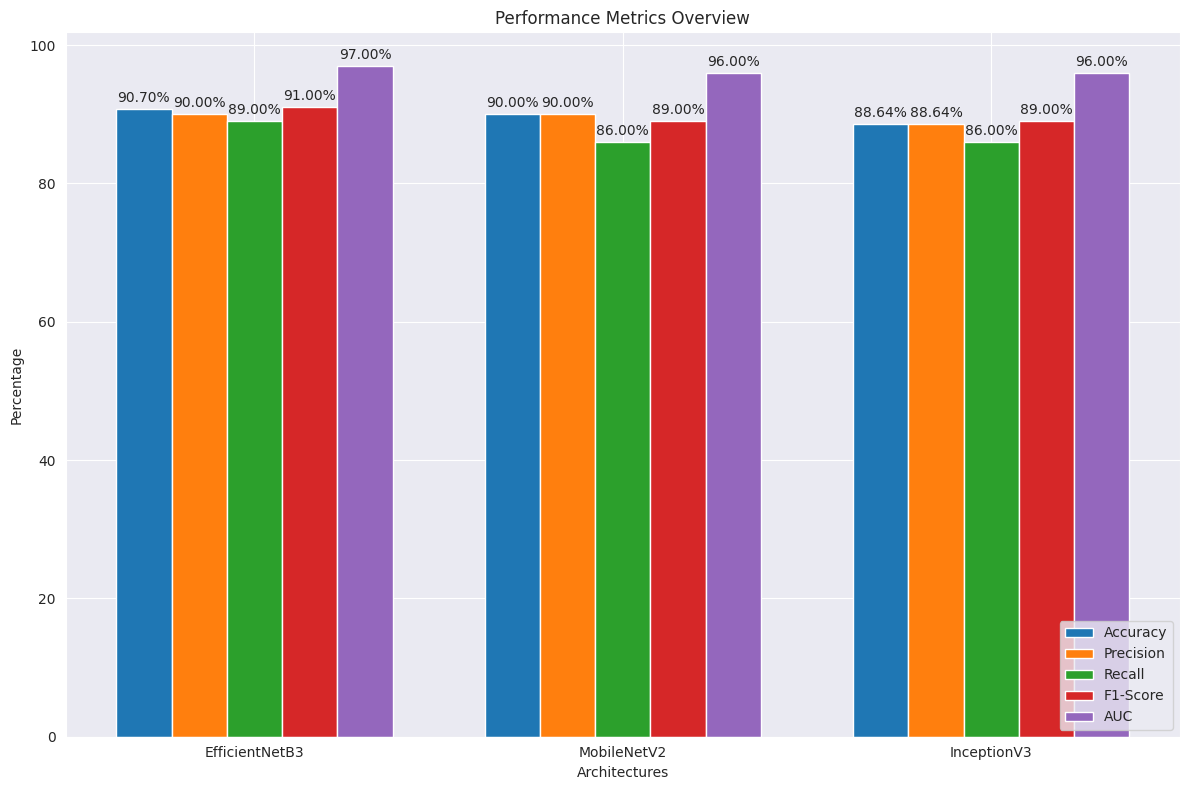

In [15]:
import matplotlib.pyplot as plt
import numpy as np

architectures = ["EfficientNetB3", "MobileNetV2", "InceptionV3"]
accuracy = [90.7, 90.0, 88.64]
precision = [90.0, 90.0, 88.64]
recall = [89.0, 86.0, 86.0]
f1_score = [91.0, 89.0, 89.0]
auc = [97, 96, 96]


width = 0.15
x = np.arange(len(architectures))

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = [
    ax.bar(x, accuracy, width, label='Accuracy', color=colors[0]),
    ax.bar(x + width, precision, width, label='Precision', color=colors[1]),
    ax.bar(x + 2 * width, recall, width, label='Recall', color=colors[2]),
    ax.bar(x + 3 * width, f1_score, width, label='F1-Score', color=colors[3]),
    ax.bar(x + 4 * width, auc, width, label='AUC', color=colors[4])
]

ax.set_xlabel('Architectures')
ax.set_ylabel('Percentage')
ax.set_title('Performance Metrics Overview')
ax.set_xticks(x + 2 * width)
ax.set_xticklabels(architectures)
ax.legend()
ax.legend(loc='lower right')
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import zipfile

# zip_file_path = 'drive/MyDrive/dataset.zip'  # Location of your zip file
# destination_path = 'drive/MyDrive/'  # Destination where you want to unzip. '.' means the current directory

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_path)

# print(f"'{zip_file_path}' has been extracted to '{destination_path}'")


#### **Function to create data frame**

In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(train_dir, test_dir):
    # train and valid dataframe
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**
<br>
Callbacks : Helpful functions to help optimize model training  <br>
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [ ]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	'''
	This function plot confusion matrix method from sklearn package.
	'''

	plt.figure(figsize= (5, 5))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [ ]:
train_dir = 'drive/MyDrive/dataset/train'
test_dir = 'drive/MyDrive/dataset/test'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(train_dir, test_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 2109 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


#### **Display Image Sample**

In [ ]:
show_images(train_gen)

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy','AUC', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 22,336,034
Trainable params: 22,297,506
Non

#### **Set Callback Parameters**

In [ ]:
# class F1ScoreCallback(tf.keras.callbacks.Callback):
#     def __init__(self, valid_gen):
#         self.validation_generator = valid_gen

#     def on_epoch_end(self, epoch, logs=None):
#         y_val = self.validation_generator.labels
#         y_pred = self.model.predict(self.validation_generator)
#         y_pred = np.argmax(y_pred, axis=1)
#         f1 = f1_score(y_val, y_pred, average='weighted')
#         print(f'F1-score: {f1:.4f}')

In [ ]:
batch_size = 40   # set batch size for training
epochs = 100   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 40  # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/inception_best_epoch", save_best_only=True)
callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch ), checkpoint_cb]

#### **Train model**

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
n
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /100    7.585   74.822   8.17078  58.333   0.00100  0.00100  accuracy     0.00    703.26 


 2 /100    5.804   83.736  10.02544  74.811   0.00100  0.00100  accuracy    11.91    18.21  
 3 /100    4.902   85.823  30.63581  73.295   0.00100  0.00100  accuracy     2.49    17.47  
 4 /100    4.191   88.336   5.29093  73.295   0.00100  0.00100  accuracy     2.93    17.66  


 5 /100    3.685   90.944   4.05505  81.818   0.00100  0.00100  val_loss    23.36    18.33  


 6 /100    3.233   93.077   3.91149  84.659   0.00100  0.00100  val_loss     3.54    17.75  


 7 /100    2.845   94.500   3.31164  83.712   0.00100  0.00100  val_loss    15.34    18.23  


 8 /100    2.535   94.927   3.59771  79.735   0.00100  0.00050  val_loss    -8.64    17.76  
 9 /100    2.284   97.060   3.60269  82.008   0.00050  0.00025  val_loss    -8.79    18.00  
10 /100    2.174   97.155   2.55940  85.795   0.00025  0.00025  val_loss    22.72    18.02  


11 /100    2.099   97.297   2.37121  86.553   0.00025  0.00025  val_loss     7.35    18.04  


12 /100    2.029   97.866   2.26789  86.553   0.00025  0.00025  val_loss     4.36    18.85  


13 /100    1.958   98.009   2.47582  85.985   0.00025  0.00013  val_loss    -9.17    17.98  
14 /100    1.906   98.198   2.13959  87.879   0.00013  0.00013  val_loss     5.66    18.50  


15 /100    1.871   98.388   2.29618  85.606   0.00013  0.00006  val_loss    -7.32    18.24  
16 /100    1.837   98.720   2.11843  87.311   0.00006  0.00006  val_loss     0.99    17.90  


17 /100    1.822   98.625   2.10226  87.500   0.00006  0.00006  val_loss     0.76    19.37  


18 /100    1.795   99.052   2.06693  88.447   0.00006  0.00006  val_loss     1.68    18.33  


19 /100    1.780   99.099   2.10265  87.500   0.00006  0.00003  val_loss    -1.73    18.18  
20 /100    1.765   98.957   2.03043  88.447   0.00003  0.00003  val_loss     1.77    18.77  


21 /100    1.758   98.862   2.04646  87.879   0.00003  0.00002  val_loss    -0.79    18.22  
22 /100    1.752   98.909   2.04568  88.068   0.00002  0.00001  val_loss    -0.75    17.86  
23 /100    1.746   98.862   2.02310  87.879   0.00001  0.00001  val_loss     0.36    18.00  


24 /100    1.738   99.194   2.01749  88.068   0.00001  0.00001  val_loss     0.28    17.69  


25 /100    1.738   99.099   2.01589  88.447   0.00001  0.00001  val_loss     0.08    19.86  


26 /100    1.736   99.004   2.02254  88.068   0.00001  0.00000  val_loss    -0.33    18.20  
27 /100    1.735   98.909   2.02145  88.258   0.00000  0.00000  val_loss    -0.28    17.95  
28 /100    1.728   99.194   2.01798  88.258   0.00000  0.00000  val_loss    -0.10    17.74  
29 /100    1.726   99.384   2.00967  88.447   0.00000  0.00000  val_loss     0.31    17.91  


30 /100    1.731   99.147   2.01211  88.447   0.00000  0.00000  val_loss    -0.12    18.18  
31 /100    1.725   99.241   2.02150  88.258   0.00000  0.00000  val_loss    -0.59    17.90  
32 /100    1.726   99.099   2.01454  88.258   0.00000  0.00000  val_loss    -0.24    17.76  
33 /100    1.732   98.815   2.01138  88.258   0.00000  0.00000  val_loss    -0.09    17.59  
34 /100    1.722   99.621   2.01522  88.258   0.00000  0.00000  val_loss    -0.28    17.47  
35 /100    1.727   99.241   2.00724  88.636   0.00000  0.00000  val_loss     0.12    18.17  


36 /100    1.725   99.052   2.00916  88.636   0.00000  0.00000  val_loss    -0.10    20.48  
37 /100    1.727   99.147   2.01613  88.258   0.00000  0.00000  val_loss    -0.44    17.98  
38 /100    1.731   99.147   2.03048  88.068   0.00000  0.00000  val_loss    -1.16    17.64  
39 /100    1.727   99.336   2.02025  88.068   0.00000  0.00000  val_loss    -0.65    18.24  
40 /100    1.727   99.384   2.00574  88.447   0.00000  0.00000  val_loss     0.08    17.65  


41 /100    1.726   99.194   2.00644  88.068   0.00000  0.00000  val_loss    -0.03    18.18  
42 /100    1.729   99.147   2.01748  87.689   0.00000  0.00000  val_loss    -0.59    18.40  
43 /100    1.727   99.194   2.01082  88.258   0.00000  0.00000  val_loss    -0.25    17.76  
44 /100    1.726   99.478   2.00948  88.258   0.00000  0.00000  val_loss    -0.19    18.80  
45 /100    1.724   99.431   1.99883  88.636   0.00000  0.00000  val_loss     0.34    17.76  


46 /100    1.729   99.004   2.00796  88.447   0.00000  0.00000  val_loss    -0.46    17.75  
47 /100    1.729   99.194   2.02159  88.068   0.00000  0.00000  val_loss    -1.14    18.00  
48 /100    1.728   99.431   2.01220  88.068   0.00000  0.00000  val_loss    -0.67    18.55  
49 /100    1.730   99.147   2.02775  87.879   0.00000  0.00000  val_loss    -1.45    17.54  
50 /100    1.726   99.478   2.02371  88.068   0.00000  0.00000  val_loss    -1.24    17.65  
51 /100    1.729   99.004   2.02486  88.068   0.00000  0.00000  val_loss    -1.30    17.58  
52 /100    1.730   98.815   2.00948  88.447   0.00000  0.00000  val_loss    -0.53    17.69  
53 /100    1.729   99.052   2.02060  88.068   0.00000  0.00000  val_loss    -1.09    17.86  
54 /100    1.728   99.336   2.00902  88.258   0.00000  0.00000  val_loss    -0.51    18.26  
55 /100    1.735   98.720   2.01767  88.636   0.00000  0.00000  val_loss    -0.94    18.59  
56 /100    1.725   99.289   2.01361  88.447   0.00000  0.00000  val_lo

#### **Display model performance**

In [ ]:
trained_model = tf.keras.models.load_model('drive/MyDrive/inception_best_epoch')

In [ ]:
from sklearn.metrics import f1_score
# Make predictions on the validation data
y_pred = trained_model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

10/10 [==============================] - 57s 5s/step


In [ ]:
# Calculate the F1 score
f1 = f1_score(test_gen.labels, y_pred, average='weighted')

print(f'F1-score: {f1:.2f}')

F1-score: 0.89


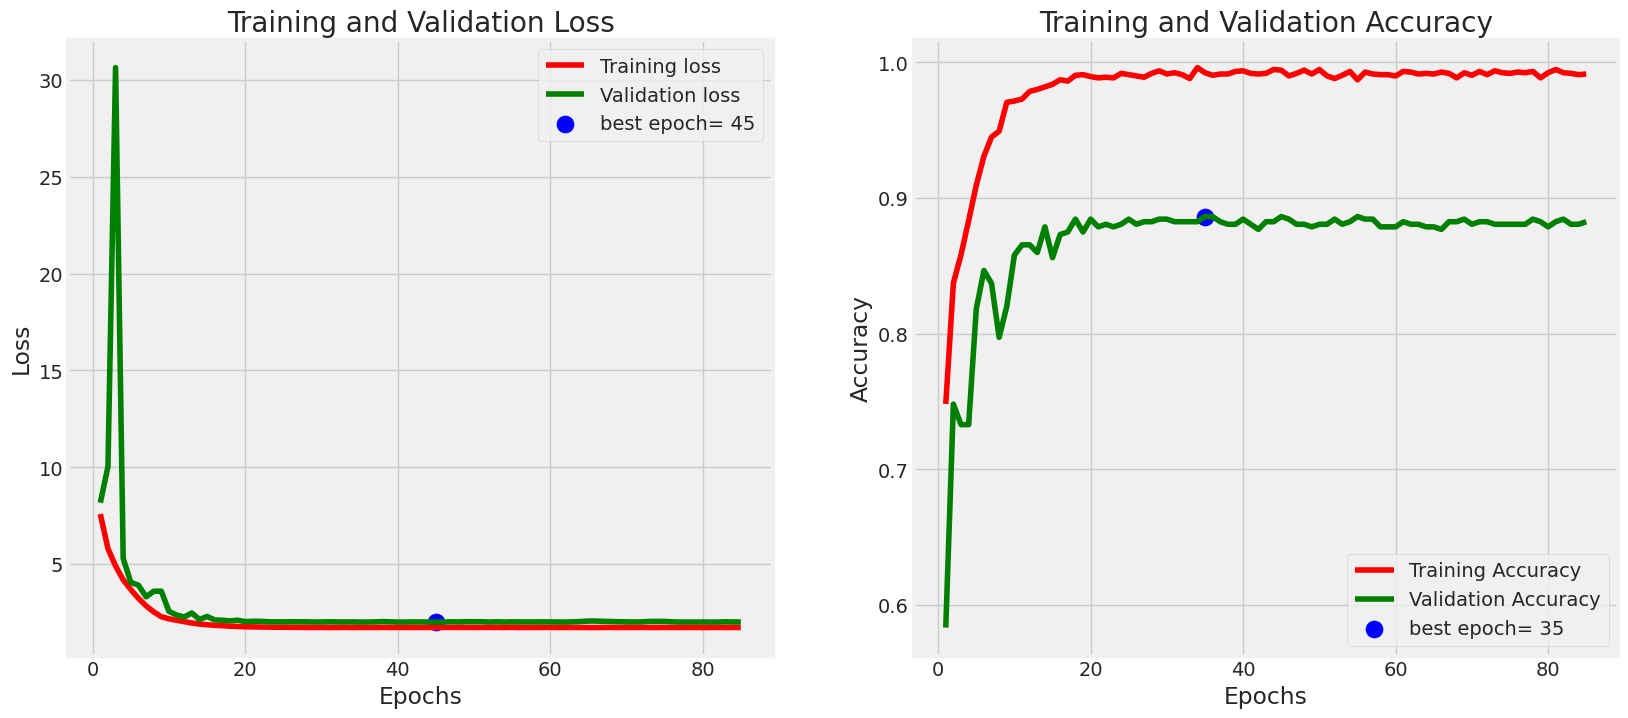

In [ ]:
plot_training(history)

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = trained_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = trained_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = trained_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/10 [==============================] - 53s 5s/step - loss: 2.0207 - accuracy: 0.8864 - auc: 0.9536 - precision: 0.8864 - recall: 0.8864
Train Loss:  1.7203896045684814
Train Accuracy:  0.9900000095367432
--------------------
Validation Loss:  1.9752986431121826
Validation Accuracy:  0.8899999856948853
--------------------
Test Loss:  2.0206754207611084
Test Accuracy:  0.8863636255264282


# **Get Predictions**

In [ ]:
preds = trained_model.predict_generator(test_gen)
print(preds)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[[0.48563346 0.51436645]
 [0.97547626 0.02452379]
 [0.98738116 0.01261876]
 ...
 [0.02231439 0.97768563]
 [0.00111386 0.99888617]
 [0.04071504 0.9592849 ]]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1
 1 0 0 1 1 0 0 1 1 

#### **Confusion Matrics and Classification Report**

Confusion Matrix, Without Normalization
[[327  33]
 [ 42 258]]
              precision    recall  f1-score   support

      benign       0.89      0.91      0.90       360
   malignant       0.89      0.86      0.87       300

    accuracy                           0.89       660
   macro avg       0.89      0.88      0.89       660
weighted avg       0.89      0.89      0.89       660



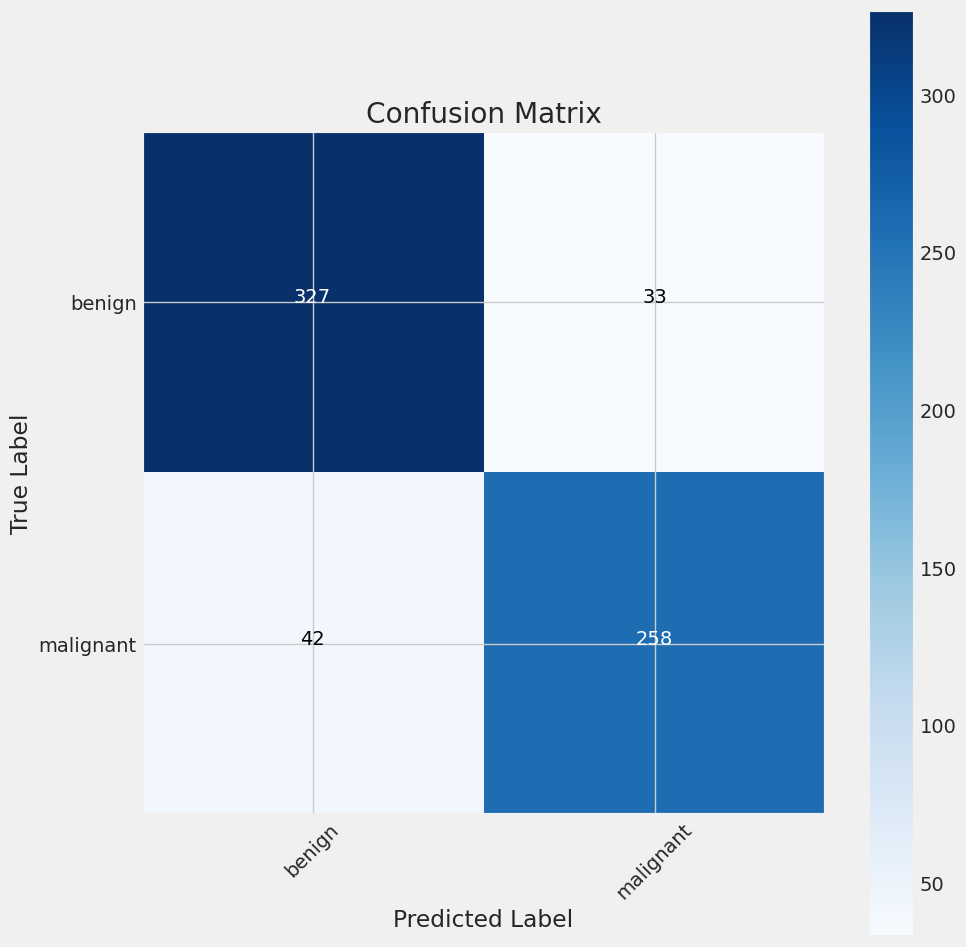

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [ ]:
import json

file_path = 'drive/MyDrive/history.json'
# Save the history data to a file
with open(file_path, 'w') as f:
    json.dump(history.history, f)

In [ ]:
import random
Labels = ["Benign", "Malignant"]

def upload(filename):
    img = cv2.imread(os.path.join(filename))
    img = cv2.resize(img, (224, 224))
    return img

def pre_result(img):
    x = trained_model.predict(np.asarray([img]))[0]
    print(x)
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}

images = random.sample(test_gen.filenames, 16)

fig = plt.figure(figsize=(20,20))

for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)


    # Add the image to the grid
    ax = fig.add_subplot(4, 4, idx+1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("class: %s\nconfidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))

plt.tight_layout()
plt.show()


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.head(30)

,loss,accuracy,auc,precision,recall,val_loss,val_accuracy,val_auc,val_precision,val_recall
0,7.584905,0.748222,0.816045,0.748222,0.748222,8.170782,0.583333,0.573844,0.583333,0.583333
1,5.803543,0.837364,0.902073,0.837364,0.837364,10.025436,0.748106,0.824800,0.748106,0.748106
2,4.901599,0.858227,0.933920,0.858227,0.858227,30.635815,0.732955,0.698501,0.732955,0.732955
3,4.191350,0.883357,0.948700,0.883357,0.883357,5.290929,0.732955,0.843474,0.732955,0.732955
4,3.684703,0.909436,0.957275,0.909436,0.909436,4.055047,0.818182,0.893095,0.818182,0.818182
5,3.232971,0.930773,0.974873,0.930773,0.930773,3.911490,0.846591,0.932164,0.846591,0.846591
6,2.845120,0.944998,0.982039,0.944998,0.944998,3.311642,0.837121,0.905287,0.837121,0.837121
7,2.535072,0.949265,0.986043,0.949265,0.949265,3.597709,0.797348,0.875660,0.797348,0.797348
8,2.283573,0.970602,0.993390,0.970602,0.970602,3.602694,0.820076,0.871228,0.820076,0.820076
9,2.174100,0.971551,0.995194,0.971551,0.971551,2.559396,0.857955,0.925815,0.857955,0.857955


In [ ]:
test_gen.reset()  # resetting generator
y_pred = trained_model.predict(test_gen, verbose=1)

10/10 [==============================] - 3s 260ms/step


ROC AUC: 0.96



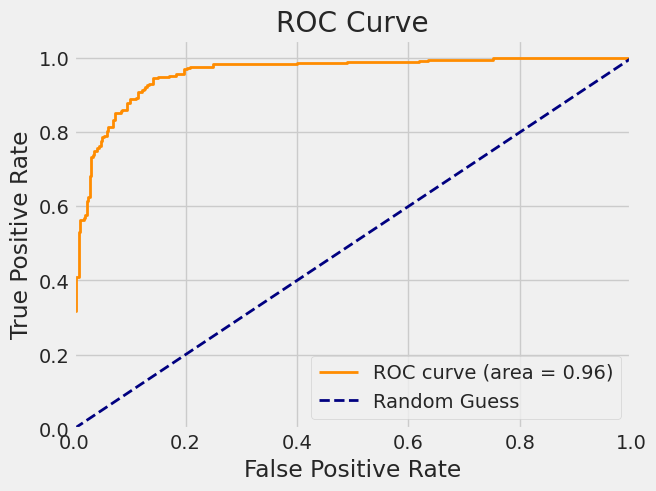

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = 2
for i in range(num_classes):
    y_pred_class_i = y_pred[:, i]
    fpr[i], tpr[i], _ = roc_curve(test_gen.labels, y_pred_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])


# print score
print('ROC AUC: %0.2f\n' % roc_auc[1])
plt.figure()
lw = 2  # Line width

plt.plot(fpr[1], tpr[1], color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label='Random Guess', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Generate predictions for validation dataset
y_pred = trained_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 [==============================] - 2s 228ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


# Create confusion matrix
cmn = confusion_matrix(test_gen.classes, y_pred_classes)
cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
print(cmn)
# Plot confusion matrix
plt.figure(figsize=(5, 5))
sn.heatmap(cmn, annot=True, cmap='Blues', fmt='.2f', xticklabels=Labels, yticklabels=Labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: ignored